In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
DATA_DIR = '../pickles'
CAPTORS_LIST = ('NO2_61FD', 'NO2_61F0', 'NO2_61EF')

In [3]:
df = pd.read_pickle(os.path.join(DATA_DIR, 'station1_normalized.pkl'))
df.head(10)

,date,ref,NO2_61FD,NO2_61F0,NO2_61EF,rh,t_grad,pressure,temp,pluvio
0,2017-09-28 10:15:00,38.5,-0.324687,-0.487027,0.433465,0.167023,-1.039505,0.375594,0.898638,0.0
1,2017-09-28 10:30:00,32.3,-0.343192,-0.325877,-0.412283,0.083982,-1.094050,0.375594,0.946776,0.0
2,2017-09-28 10:45:00,38.5,-0.010107,-0.161505,-0.198236,0.065528,-0.984961,0.375594,0.970844,0.0
3,2017-09-28 11:00:00,29.7,-0.386370,-0.554710,-0.339194,-0.063647,-0.984961,0.356064,1.091187,0.0
4,2017-09-28 11:15:00,19.4,-0.386370,-0.422567,-0.412283,-0.146688,-1.203138,0.375594,1.163393,0.0
5,2017-09-28 11:30:00,10.8,-0.386370,-0.619170,-0.412283,-0.238957,-1.039505,0.375594,1.259668,0.0
6,2017-09-28 11:45:00,12.4,-0.386370,-0.586940,-0.412283,-0.358905,-1.203138,0.375594,1.283736,0.0
7,2017-09-28 12:00:00,12.3,-0.386370,-0.619170,-0.412283,-0.405039,-1.148594,0.375594,1.307805,0.0
8,2017-09-28 12:15:00,9.7,-0.386370,-0.619170,-0.412283,-0.423493,-1.312227,0.356064,1.355942,0.0
9,2017-09-28 12:30:00,13.8,-0.386370,-0.619170,-0.412283,-0.552668,-1.475859,0.356064,1.548491,0.0


In [4]:
def from_dataframe_to_xy(df, captor_idx):
    return (np.array(df[[CAPTORS_LIST[captor_idx], 'temp', 'rh', 't_grad', 'pressure', 'pluvio']]),
            np.array(df['ref']))

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

In [5]:
def mlp(input_shape, loss='mse', optimizer='adam'):
    model = Sequential()

    model.add(Dense(32, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    opti = Adam(lr=0.0003)
    model.compile(loss=loss, optimizer=opti)
    return model

- CAPTOR: NO2_61FD
	 Score = 396.173527699


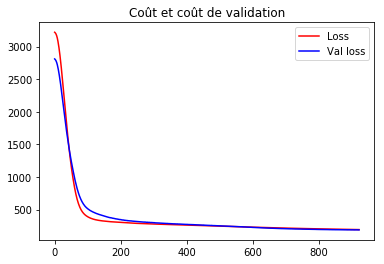

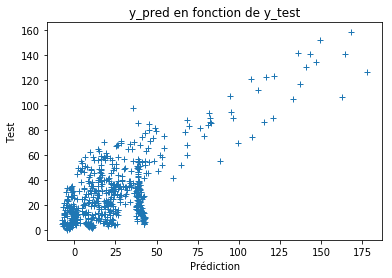

- CAPTOR: NO2_61F0
	 Score = 165.828045472


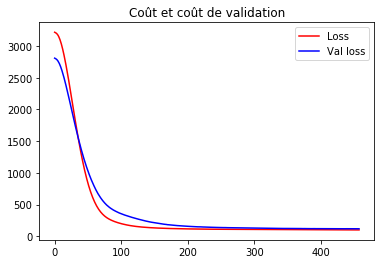

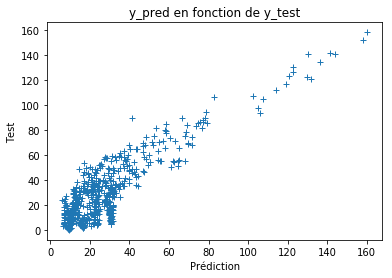

- CAPTOR: NO2_61EF
	 Score = 386.433397104


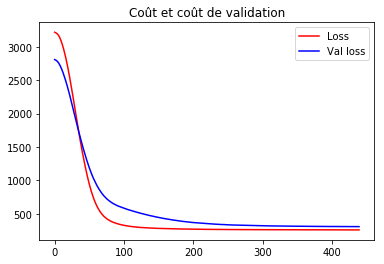

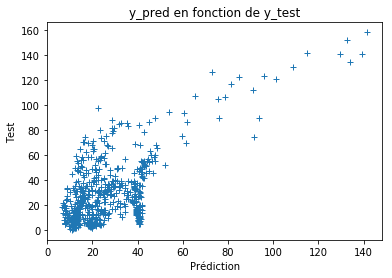

In [8]:
df_train, df_test = split_dataframe(df, 0.5)
df_valid, df_test = split_dataframe(df_test, 0.5)

### BIG LOOP TO TRAIN ON EACH MICROCAPTOR INDEPENDANTLY

for i in range(len(CAPTORS_LIST)):
    print("- CAPTOR: {}".format(CAPTORS_LIST[i]))
    X_train, y_train = from_dataframe_to_xy(df_train, i)
    X_valid, y_valid = from_dataframe_to_xy(df_valid, i)
    X_test, y_test = from_dataframe_to_xy(df_test, i)
    
    model = mlp(X_train.shape[1])
    early_stopping = EarlyStopping(patience=10)
    history = model.fit(X_train, y_train, \
                        batch_size=32, \
                        epochs=10000, \
                        validation_data=(X_valid, y_valid), \
                        callbacks=[early_stopping],
                        verbose=0)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print("\t Score = {}".format(str(score)))
    
    y_pred = model.predict(X_test)
    plt.title('Coût et coût de validation')
    line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
    line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
    first_legend = plt.legend(handles=[line1, line2], loc=1)

    plt.show()

    plt.title('y_pred en fonction de y_test')

    plt.plot(y_pred[:], y_test[:], '+')
    plt.ylabel('Test')
    plt.xlabel('Prédiction')
    plt.show()

- CAPTOR: NO2_61FD
	 Score = 382.615653638


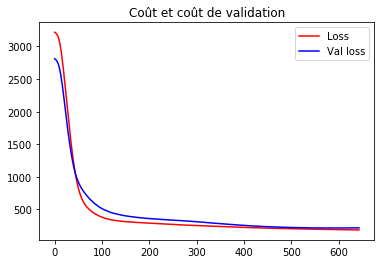

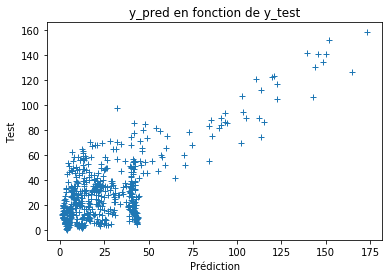

- CAPTOR: NO2_61F0
	 Score = 161.250373386


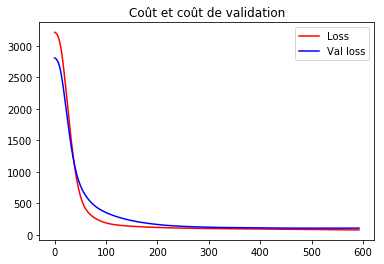

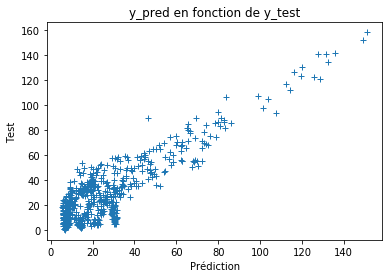

- CAPTOR: NO2_61EF
	 Score = 387.346246985


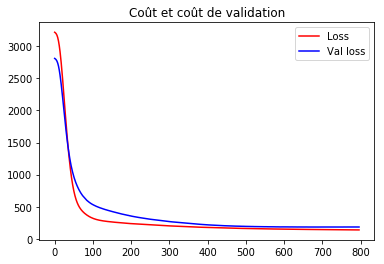

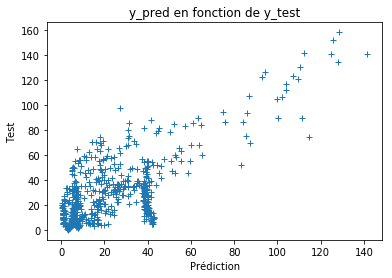

In [12]:
from keras.layers import GRU
def gru(nb_units, input_shape, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_shape, activation='relu'))#, recurrent_dropout=1))
    #model.add(Dense(nb_units, activation='relu'))
    
    opti = Adam(lr=0.0003)
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    model.compile(loss=loss, optimizer=opti)
    
    return model
### BIG LOOP TO TRAIN ON EACH MICROCAPTOR INDEPENDANTLY

for i in range(len(CAPTORS_LIST)):
    print("- CAPTOR: {}".format(CAPTORS_LIST[i]))
    X_train, y_train = from_dataframe_to_xy(df_train, i)
    X_valid, y_valid = from_dataframe_to_xy(df_valid, i)
    X_test, y_test = from_dataframe_to_xy(df_test, i)
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    model = gru(32, X_train.shape[1:])
    early_stopping = EarlyStopping(patience=50)
    history = model.fit(X_train, y_train, \
                        batch_size=32, \
                        epochs=10000, \
                        validation_data=(X_valid, y_valid), \
                        callbacks=[early_stopping],
                        verbose=0)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print("\t Score = {}".format(str(score)))
    
    y_pred = model.predict(X_test)
    plt.title('Coût et coût de validation')
    line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
    line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
    first_legend = plt.legend(handles=[line1, line2], loc=1)

    plt.show()

    plt.title('y_pred en fonction de y_test')

    plt.plot(y_pred[:], y_test[:], '+')
    plt.ylabel('Test')
    plt.xlabel('Prédiction')
    plt.show()